# Building MicroGrad

## Derivative of an Example Function

* Build an intuitive understanding of derivatives
* Let's look at the example function:

  $f(x)=3x^2-4x+5$

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x +5

$f(3.0)=20.0$

In [3]:
f(3.0)

20.0

* plotting the whole function

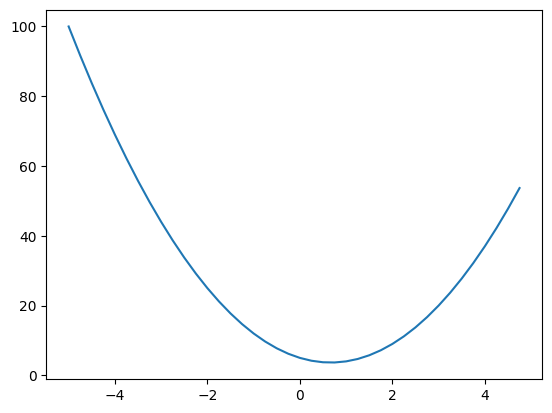

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

* In calculus, we would derive the function symbolically
* Using product rule and such we would arrive at an expression for the derivatives
* Plugging in the different x values would give us the slope at each point
* But this is not done in nns, as the expressions are massive
* Instead we need to know what derivatives are measuring
* The mathematical definition of a derivative is as follows:
  
  $\textit{L} = \lim _\limits{h \to 0}\frac{f(a+h)-f(a)}{h}$

* At point $a$, you slightly bump up $a$ by $h$, how does the function respond?
* Does it go up or down and by how much?
* We can evaluate this numerically using a small $h$
* We take the difference in $y$ and normalize it to by h to 1 to get the slope at $x$

In [5]:
h = 0.001
x = 3.0
(f(x+h) - f(x))/h

14.00300000000243

* We cross check symbolically:

  $f(x)=3x^2-4x+5$
  
  $f^{\prime}(x)=6x-4$

  $f^{\prime}(3)=6*3-4=14$

## Gradient: Partial Derivatives of multivariate Functions

* If we have multiple variables, the partial derivatives tell us the influence of each variable on the function
* Example for this section:

    $f(a,b,c)=a \cdot b+c$
  
* Partial derivatives are normally denoted as follows: $\frac{\partial f}{\partial a}$, $\frac{\partial f}{\partial b}$ etc.

In [6]:
a = 2.0
b = -3.0
c = 10.0
d = a*b+c
print(d)

4.0


In [7]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b +c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


* We bumped $a$ and evaluated it's influence on $d$
* Think through: $a$ becomes slightly more positive
* But is multiplied by a negative $b$, so less will be added to $d$
* So slope goes down
* Checks out symbolically, because deriving by $a$ will only leave $b$, which is $-3.0$

* What is the influence of $b$ on $f$?

In [8]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b += h
d2 = a*b +c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0002
slope 2.0000000000042206


* If $b$ is nudged then more of $a$ is added to the function
* $a$ a is positive, so $b$ has a positive slope
* Checks out symbolically, as $\frac{dd}{db}$ is $a$, which is $2.0$

* Lastly, the influence of $c$ on $f$

In [9]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b +c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


* $f$ increases by the same amount that $c$ increases
* so the slope, or the proportionality constant is $1.0$
* Also symbolically $\frac{dd}{dc}=1.0$

## Gradients/Derivatives in Neural Nets

* Now we understand derivatives and we want to move to NNs
* NNs will be massive mathematical expressions
* We will build a datastructure that will maintain this expression as we build it

### Datastructure and Visualization

In [10]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        
    def __repr__(self):
        return f"Value(data={self.data})"
     
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

* Math operations are enabled with a class by defining double underscore methods like ```__mul__```
* Operations pass the operators to the new Value object, which will build the graph
* We store the operator that generated the value as a string inside the new Value
* ```self.label``` and ```self._op``` are used for visualizing the graph for now

* We will test the ```Value``` class using the expression:

    $L(a,b,c,f)=(a*b+c)*f$ for $L(2,-3,10,-2)$

In [11]:
a = Value(2.0,  label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b;      e.label='e'
d = e + c;    d.label='d'
f = Value(-2.0, label='f')
L = d * f;    L.label='L'
L.data

-8.0

* And visualize the expression graph with graphviz

In [12]:
from graphviz import Digraph

def trace(root):
    #builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        # v seen for the first time
        if v not in nodes:
            nodes.add(v)
            # add edges for all children and call build recursively
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    
    nodes, edges = trace(root)
    for n in nodes:
        # create rectangles for all nodes first
        uid = str(id(n))
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        # create circles for all ops and an edge to the containing node
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)

    # now that all nodes exist, create edges to the ops circles in which they are used
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

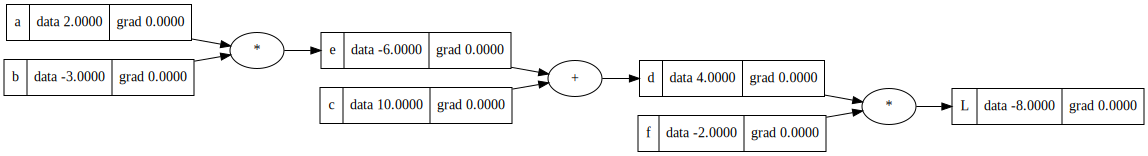

In [13]:
draw_dot(L)

### Manually Computing Gradients 

* The graph shows a forward pass: the inputs a,b,c and f are evaluated to $L=-8.00$
* Now we'd like to run backpropagation, which calculates the gradient along all the intermediate values
* So we will compute the gradient of every node with respect to $L$
* Starting with $L$ itself, the derivative of $L$ with respect to $L$ is $1.0$
* In a neural net, the inputs will be the weights and we are interested in the influence of a weight on the loss function
* Some inputs will be data, which we will not change as the data is fixed, but the weights can be tuned
* The gradient/derivative will be stored in each node in ```self.grad```, which we initially will set to $0.0$
* We will compute the gradients manually at first and will validate it numerically as done before
* For numerical validation, we use the method from above:

In [14]:
def lol():

    h = 0.0001
    
    a = Value(2.0,  label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b;      e.label='e'
    d = e + c;    d.label='d'
    f = Value(-2.0, label='f')
    L = d * f;    L.label='L'
    L1 = L.data

    a = Value(2.0 + h,  label='a')  # bumping a by h
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b;      e.label='e'
    d = e + c;    d.label='d'
    f = Value(-2.0, label='f')
    L = d * f;    L.label='L'
    L2 = L.data

    print((L2 - L1)/h)              # and calculate the derivativ of L with respect to a

lol()

6.000000000021544


* $a$ gets bumped by $h$, so $b$ gets multiplied by $h$
* In turn, $f$ multiplies $b$ so it is also multiplied by $h$
* Normalizing by $h$ gives a derivative of $b*f=-3*-2=6$
* But let's start at the end. What is the gradient of $L$, so the influence of $L$ on $L$?

### Initial Gradient

* If we bump $L$ by $h$, $L$ will increase by $h$. Normalizing by $h$ gives $1.0$.
* In other words $L$ is directly proportional to itself
* So the gradient of $L$ with respect to $L$ is 1.0
* That is our first manually calculated derivative, which we set and redraw the graph

In [15]:
L.grad = 1.0

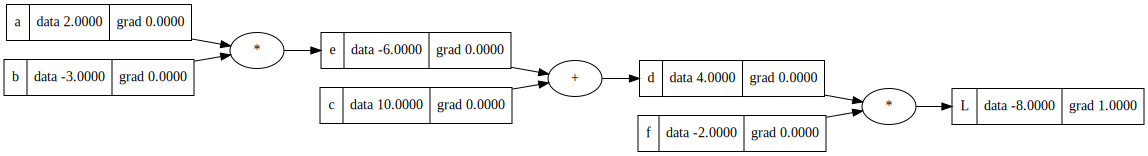

In [16]:
draw_dot(L)

### Backpropagating through Multiplication

* Now we want $\frac{dL}{dd}$
* $d$ is part of a multiplication with $f$, so nudging $d$ adds that nudge times $f$ to $L$
* We can verify symbolically

  $L= d*f$
  
  $\frac{dL}{dd} = ((d+h)*f - d*f)/h$
  
  $\frac{dL}{dd} = ( d*f + h*f - d*f )/h$
  
  $\frac{dL}{dd} = ( h*f )/h$

  $\frac{dL}{dd} = f$

* The same goes for the derivative with respect to $f$, which is just $d$
* So the derivatives of the operands in a multiplication is basically the value of the other operands value

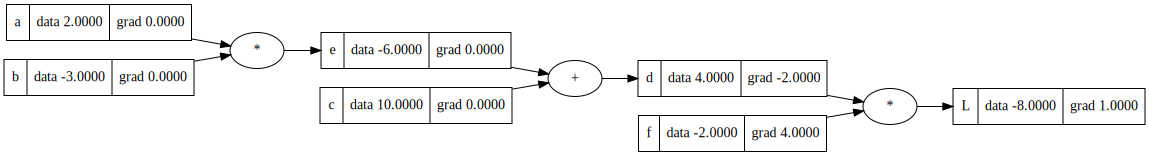

In [17]:
d.grad = f.data
f.grad = d.data
draw_dot(L)

* Let's check also numerically with $f$

In [18]:
def lol():

    h = 0.0001
    
    a = Value(2.0,  label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b;      e.label='e'
    d = e + c;    d.label='d'
    f = Value(-2.0, label='f')
    L = d * f;    L.label='L'
    L1 = L.data

    a = Value(2.0,  label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b;      e.label='e'
    d = e + c;    d.label='d'
    f = Value(-2.0 + h, label='f')  # bumping f by h
    L = d * f;    L.label='L'
    L2 = L.data

    print((L2 - L1)/h)              # and calculate the derivativ of L with respect to f

lol()

3.9999999999995595


### Nested Derivatives

* Now to the crux of backpropagation: deriving with respect to nodes more deeply nested
* For example how sensitive is $L$ to $c$? It's change goes through $d$ to $L$
* We know the impact of $d$ on $L$ and we can understand the impact of $c$ onto $d$
* Now we need to put this information together to understand how $c$ impacts $L$
* Let's start by understanding the impact of $c$ on $d$

### Backpropagating through Addition
    
  * It is apparent that the derivative of $d$ w.r.t. $c$ is $1.0$
  * We can prove this using the derivative formula $\frac{df}{dx}=(f(x+h) - f(x))/h$
    
    $d = c + e$

    $\frac{dd}{dc}=(c+h+e - (c+e))/h$
    
    $\frac{dd}{dc}=(c+h+e-c-e)/h$
    
    $\frac{dd}{dc}=(h)/h$
    
    $\frac{dd}{dc}=1.0$

  * By symmetrie the local derivative with respect to $d$ is also $1.0$ 

* The local derivatives give the impact on $d$
* But the expression is embedded in other expressions that finally evaluate to $L$
* So we apply the chain rule to find the impact of $c$ and $e$ on the final result $L$

#### Digression: Chain Rule

* The derivative of a function gives us the rate of change of the function value w.r.t. each point
* I.e. the function $f(x)=x^2$ has a rate of change of $2x$ at each point, so $2$ at $x=1$
* $x$ can be dependent on a variable itself, like in $(sin(y))^2$ with $x(y)=sin(y)$
* The rate of change of $x$ w.r.t. $y$ is $cos(y)$ so $~0.54$ at $y=1$
* So nudging $y$ by one will increase $x$ by $~0.54$
* Nudging $x$ by one would increase $f$ by $2$, but $x$ is only nudged by $~0.54$
* So the final impact of nudging $y$ by one on $f$ is $2*~0.54$
* This is the general chain rule: $\frac{df(g(x))}{dx}=\frac{df}{dg}*\frac{dg}{dx}$

### Applying the Chain rule

* Now we apply the chain rule

     $\frac{dL}{dc}=\frac{dL}{dd}*\frac{dd}{dc} \Rightarrow \frac{dL}{dc}=-2.0*1.0$

     $\frac{dL}{de}=\frac{dL}{dd}*\frac{dd}{de} \Rightarrow \frac{dL}{de}=-2.0*1.0$

* So when the gradient backpropagates through addition, the gradient of the successor node just propagates verbatim to it's child nodes


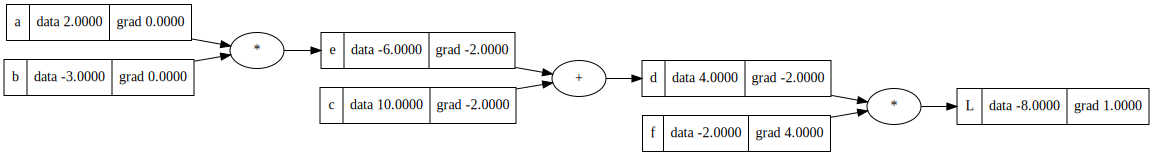

In [19]:
c.grad = d.grad * 1.0
e.grad = d.grad * 1.0
draw_dot(L)

* Again, we validate numerically

In [20]:
def lol():

    h = 0.0001
    
    a = Value(2.0,  label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b;      e.label='e'
    d = e + c;    d.label='d'
    f = Value(-2.0, label='f')
    L = d * f;    L.label='L'
    L1 = L.data

    a = Value(2.0,  label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    c.data +=h                      # nudge c by h
    e = a*b;      e.label='e'
    d = e + c;    d.label='d'
    f = Value(-2.0, label='f')
    L = d * f;    L.label='L'
    L2 = L.data

    print((L2 - L1)/h)              # and calculate the derivative of L with respect to c

lol()

-1.9999999999953388


In [21]:
def lol():

    h = 0.0001
    
    a = Value(2.0,  label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b;      e.label='e'
    d = e + c;    d.label='d'
    f = Value(-2.0, label='f')
    L = d * f;    L.label='L'
    L1 = L.data

    a = Value(2.0,  label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b;      e.label='e'
    e.data += h                     # nudge e by h
    d = e + c;    d.label='d'
    f = Value(-2.0, label='f')
    L = d * f;    L.label='L'
    L2 = L.data

    print((L2 - L1)/h)              # and calculate the derivative of L with respect to e

lol()

-1.9999999999953388


### Recurse one Last Time

* $e$ was produced by $a*b$
* The local derivative of an operand of a multiplication is the value of the other operand
* The global derivative is just the local multiplied by the gradient of the result (chain rule)

  $\frac{dL}{da}=\frac{dL}{de}*\frac{de}{da} \Rightarrow \frac{dL}{da}=-2.0*-3.0$

  $\frac{dL}{db}=\frac{dL}{de}*\frac{de}{db} \Rightarrow \frac{dL}{da}=-2.0*2.0$

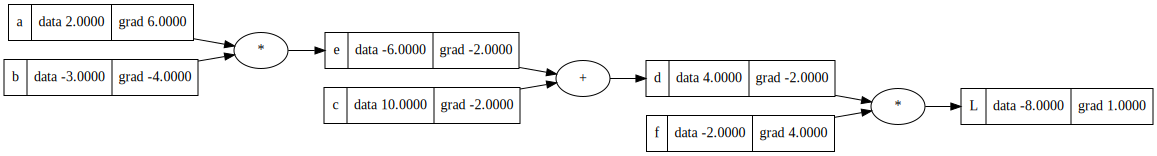

In [22]:
a.grad = e.grad * b.data
b.grad = e.grad * a.data
draw_dot(L)

In [23]:
def lol():

    h = 0.0001
    
    a = Value(2.0,  label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b;      e.label='e'
    d = e + c;    d.label='d'
    f = Value(-2.0, label='f')
    L = d * f;    L.label='L'
    L1 = L.data

    a = Value(2.0+h,  label='a')   # nudge a by h
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b;      e.label='e'
    d = e + c;    d.label='d'
    f = Value(-2.0, label='f')
    L = d * f;    L.label='L'
    L2 = L.data

    print((L2 - L1)/h)              # and calculate the derivative of L with respect to a

lol()

6.000000000021544


In [24]:
def lol():

    h = 0.0001
    
    a = Value(2.0,  label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b;      e.label='e'
    d = e + c;    d.label='d'
    f = Value(-2.0, label='f')
    L = d * f;    L.label='L'
    L1 = L.data

    a = Value(2.0,  label='a')
    b = Value(-3.0+h, label='b')      # nudge b by h
    c = Value(10.0, label='c')
    e = a*b;      e.label='e'
    d = e + c;    d.label='d'
    f = Value(-2.0, label='f')
    L = d * f;    L.label='L'
    L2 = L.data

    print((L2 - L1)/h)              # and calculate the derivative of L with respect to b

lol()

-4.000000000008441


### Gradient Ascent

* Now we computed all the partial derivatives of $L$, which together make up the gradient
* The gradient tells us in which direction to step, to make $L$ go up
* If a derivative is negative, we go into the opposite direction
* If it is positive, we go into the same direction
* We step proportional to the magnitude of the derivative, because the steeper the slope, the farther we are away from an optimum
* This can be achieved by just adding the derivative to the position
* We only do this for all leave nodes, as we only control the inputs

In [25]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

* Now we reevaluate the function with the new inputs
* We call this the forward pass
* The function value should go up

In [26]:
    e = a*b
    d = e + c
    L = d * f
    print(L.data)

-7.286496


## Backpropagating through Multilinear Perceptrons (MLPs)

* We will do one additional manual backpropagation through a more complex mathematical expression
* The expression is the mathematical model of a neuron
* This neuron model will be used to build out neural networks
* Below, a schematic arrangement of real neurons in a neural net:

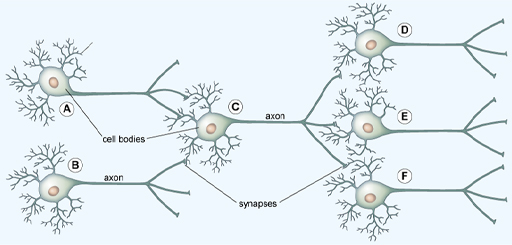

* Such a neural net is modeled as follows:

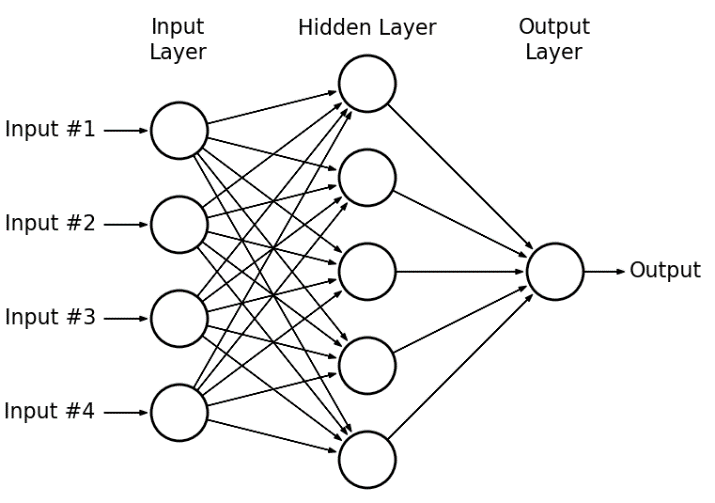

* A number of inputs go into a layer of neurons
* These nerons are fully connected to a hidden layer
* The hidden layer is fully connected to an output neuron

### Modeling a Neuron

* We model each neuron with a simplified mathematical function:

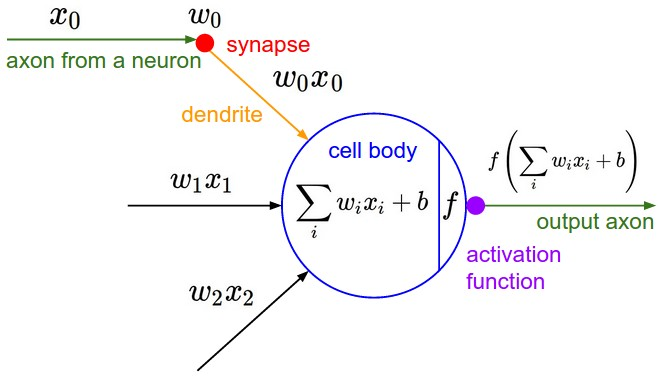


* These neurons have synapses that have weights on them
* The synapse interacts with its input multiplicatively
* There are multiple cell inputs flowing into the cell body
* The cell body has a bias, which is a sort of trigger happiness of the neuron
* All products from the synapses are added together and the bias is also added
* The result goes into an activation function, which is some kind of squashing function like sigmoid or tanh

* Let's have a look at the tanh function

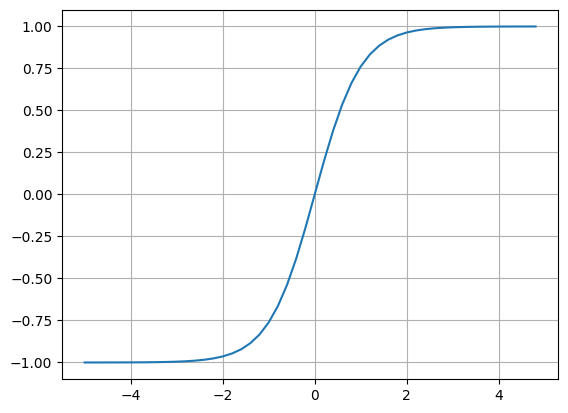

In [27]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()

* We can see that the inputs that come in get squashed
* Everything below -2 and above 2 gets squashed to -1 and 1 respectively
* 0 stays at zero
* Values between -2 and 2 will start from -1 and smoothely go up to 1 and then plateau out
* So basically the output of the neuron is the activation function applied to the dot product of the weights with the inputs

  $N(\mathbf{x})=tanh(\mathbf{x} \cdot \mathbf{w} + \mathbf{b})$

### Implementing a Neuron

* Let's spell it out in code

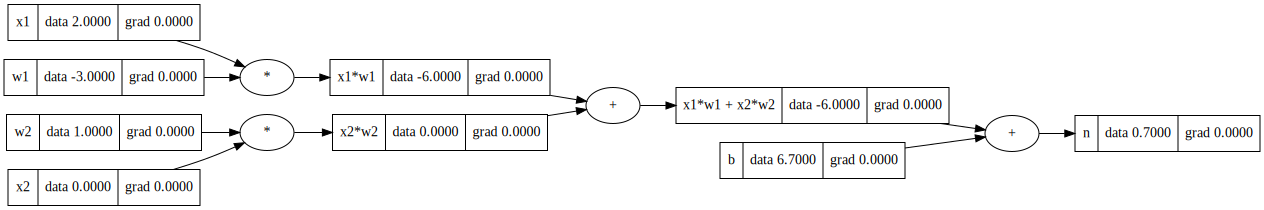

In [28]:
#inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w1
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.7, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2=x1w1+x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

draw_dot(n)

### Adding $tanh$ to the Value Class

* Now we need to bring this result through the activation function tanh
* We cannot compute $tanh$ on the ```Value``` class yet, because we only implemented plus and times
* For $tanh$ we would also need exponentiation as tanh can be expanded as follows:

  $tanh(x)=\frac{e^{2x}+1}{e^{2x}-1}$

* So one way to enable tanh on ```Value``` is to implement exponentiation
* But for the purpose of this example we want to show that you don't always need the most atomic pieces in this ```Value``` object
* We can implement functions at any level of abstraction
* The only thing that matters is that we know how to differentiate through that function
* So we will implement $tanh$ directly in ```Value```

In [29]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        
    def __repr__(self):
        return f"Value(data={self.data})"
     
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x)+1) 
        out = Value(t, (self, ), 'tanh')
        return out

* Now we can do $tanh$ on the result
* Need to repeat the computation of n, so it's ```Value``` object has the $tanh$ method

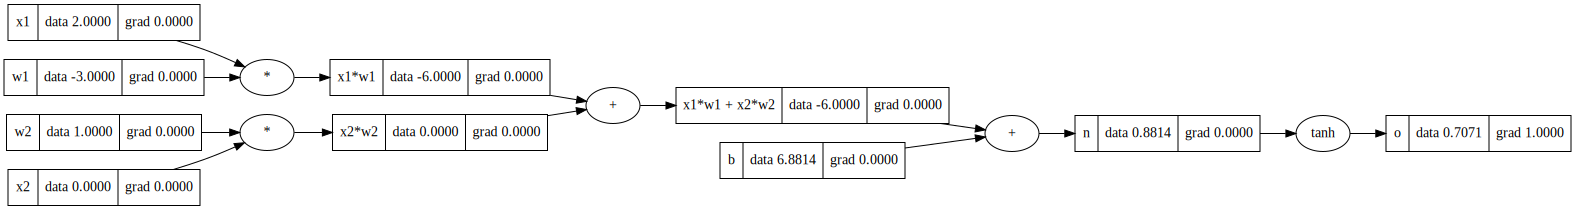

In [30]:
b = Value(6.8813735870195432, label='b')
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.grad = 1.0

draw_dot(o)

* In the graph we can see that $n$ doesn't get too squashed out because it is not too large
* Increasing the bias would result in something close to $1.0$
* We set the bias to $6.8813735870195432$ so the numbers that we get from backprop come out nice

* Now we need to manually compute the derivative of $tanh$
* Looking it up in wikipedia we get: $\frac{do}{dn}=1-tanh(n)^2$
* In code: 

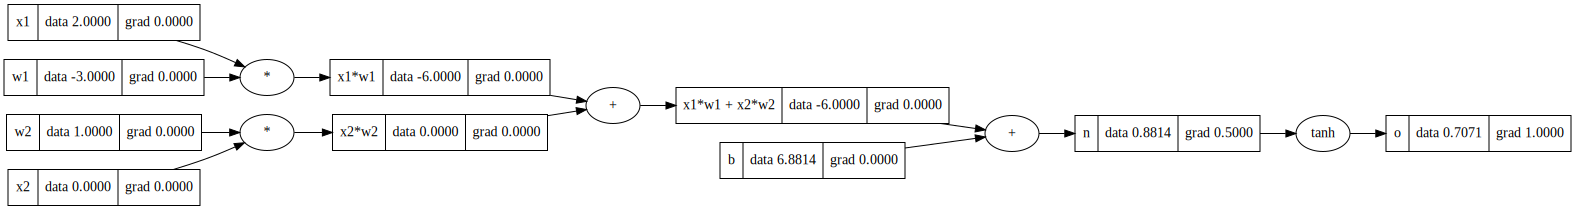

In [31]:
n.grad = 1-o.data**2
draw_dot(o)

* backpropagating through the plus operator just distribute the gradient to it's operands
* Same for the plus operator before it
* At the leafs we have the multiplication operators
* Their operands receive as their gradient the data value of their respective operand multiplied by the gradient of their result:

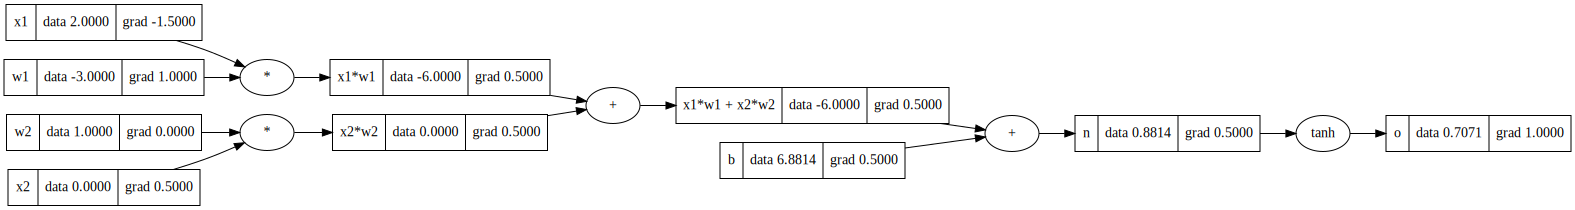

In [32]:
# propagate through plus
b.grad = n.grad
x1w1x2w2.grad = n.grad
# propagate through plus
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad
# propagate through multiplication
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

draw_dot(o)

### Automating Backpropagation

* Now we extend the Value class with the method we used for backpropagating through different operations
* The class will receive a ```_backward``` method, which will be assigned different backprop functions depending on the operation
* These functions will be set by the method that implements the operation

In [33]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self._backward = lambda: None                                   # initialized with an empty function
        self.label = label
        self.grad = 0.0
        
    def __repr__(self):
        return f"Value(data={self.data})"
     
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():                                                # For addition, just copy out.grad to it's operands
            self.grad  = out.grad
            other.grad = out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad  = other.data * out.grad
            other.grad = self.data  * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x)+1) 
        out = Value(t, (self, ), 'tanh')
        def backward():
            self.grad = (1-t**2)*out.grad
        out._backward = backward
        return out

* Now ```o.grad``` should backpropagate automatically, when we call ```_backward()``` on ```o```
* But we still need to set ```o.grad = 1.0``` as the base case manually

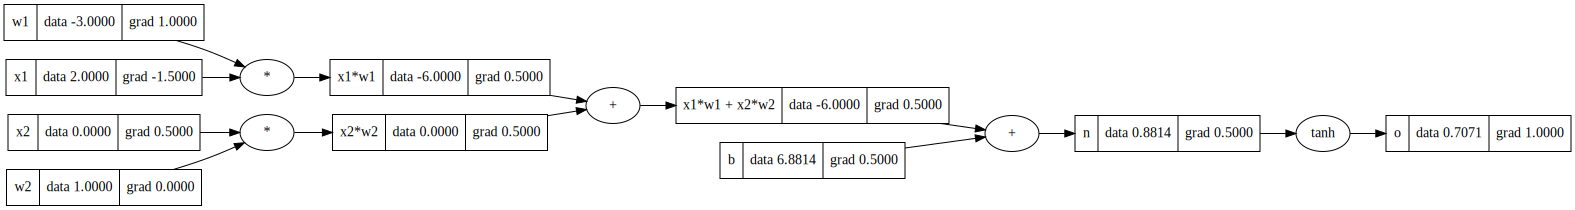

In [34]:
#inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w1
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2=x1w1+x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# tanh
o = n.tanh(); o.label = 'o'
o.grad = 1.0

# AUTOMATIC BACKPROP, BABY!
o._backward()
n._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()


draw_dot(o)

* Compare to the manual computation of the gradient to see that it is now almost automated
* To fully automate, we need to call the ```_backward()``` methods in the right order
* This order must ensure that when a ```_backward()``` of a node is called then all ```_backward()``` methods after it have already been called
* This can be achieved with topological sort, which works for directed acyclic graphs
* The ```Value``` class will be extended with a ```backward()``` method
* ```backward()``` will do topological sort, initialize the gradient to $1.0$ and call ```_backward()``` on all nodes in reverse of the sorted list

In [35]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = _children
        self._op = _op
        self._backward = lambda: None                                   # initialized with an empty function
        self.label = label
        self.grad = 0.0
        
    def __repr__(self):
        return f"Value(data={self.data})"
     
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():                                                # For addition, just copy out.grad to it's operands
            self.grad  = out.grad
            other.grad = out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad  = other.data * out.grad
            other.grad = self.data  * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x)+1) 
        out = Value(t, (self, ), 'tanh')
        def backward():
            self.grad = (1-t**2)*out.grad
        out._backward = backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        

* recompute the neuron expression, so all grads are initialized to $0.0$ again
* Compare results to the manually computed results

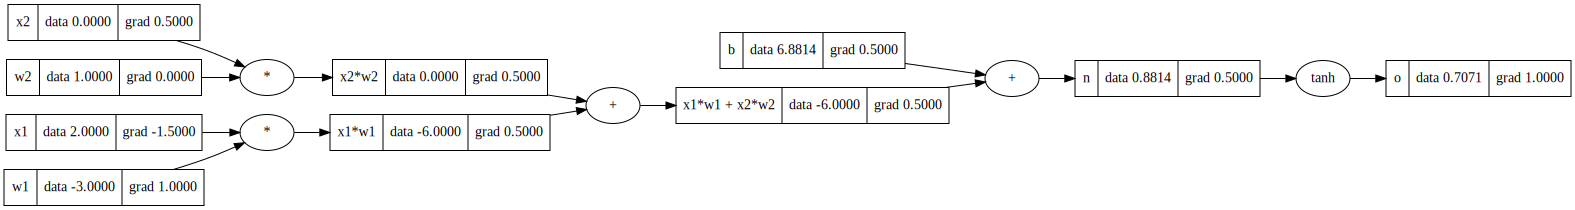

In [36]:
#inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w1
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2=x1w1+x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# tanh
o = n.tanh(); o.label = 'o'

o.backward()
draw_dot(o)

### Bug: Chain Rule accumulates Gradients in multivariate Expressions

* If a variable is used multiple times in an expression, then the gradient is overwritten during multiple invokations of ```backward()```

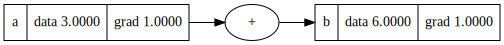

In [37]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

* Another example, where two variables are multiplied for one result and added for another
* In this case backpropagation from the multiplication overwrites the backprop from addition

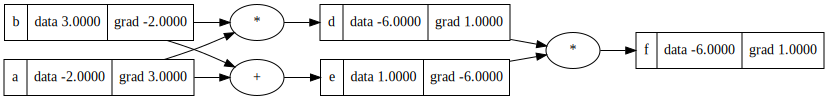

In [38]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'

f.backward()

draw_dot(f)

* The solution is to apply the multivariate chain rule, which requires to accumulate gradients

In [39]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = _children
        self._op = _op
        self._backward = lambda: None
        self.label = label
        self.grad = 0.0
        
    def __repr__(self):
        return f"Value(data={self.data})"
     
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad  += out.grad                                              # Accumulating the gradient
            other.grad += out.grad                                              # Accumulating the gradient
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad  += other.data * out.grad                                 # Accumulating the gradient
            other.grad += self.data  * out.grad                                 # Accumulating the gradient
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x)+1) 
        out = Value(t, (self, ), 'tanh')
        def backward():
            self.grad += (1-t**2)*out.grad                                      # Accumulating the gradient
        out._backward = backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        

* Test the new method with our multivariate example
* Gradients of $a$ and $b$ should receive the $-6$ through the plus and accumulate it with $3.0*1.0$ for $a$ and $-2.0*1.0$ for $b$

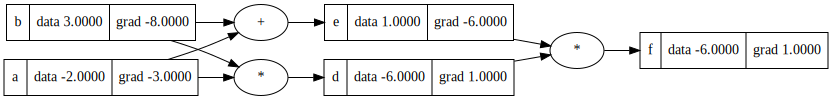

In [40]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'

f.backward()

draw_dot(f)

### Building out $tanh$
* Next, we are going to build out $tanh$ ourselves instead of calling a library function
* Our goal is to show that this will not change the results
* And we can extend the ```Value``` class with more operations (exponentiation, subtraction, division)
* So $tanh$ will become the result of the following expression

  $tanh(x)=\frac{e^{2x}-1}{e^{2x}+1}$

* We will first describe all adjustments and then implement in one go at the end

#### Adding constant Values

* We can add two instances of the ```Value``` class, but we cannot add a number to an instance 

In [41]:
a = Value(2.0, label='a')
a + 1.0

AttributeError: 'float' object has no attribute 'data'

* Solution: if ```other``` is not an instance of value, convert to ```Value``` instance in the operator methods

  ```other = other if isinstance(other, Value) else Value(other)``` 

* $a*2$ works now, but $2*a$ doesn't, because $2$ doesn't have a ```__mul___``` method
* python will look for the ```__rmul__``` method on the other operand
* So we will swap the order of operands in ```__rmul__```

   ```python
   return self * other
   ```

#### Exponentiation

* We will just use ```math.exp()``` inside the new ```exp()``` method
* The ```_backward()``` method will backprop through ```exp()```
* The derivative of $e^x$ is also $e^x$, so

  ```python
  self.grad += out.data * out.grad
  ``` 

#### Division

* Division will be expressed with operations we already have
* $a/b = a*(1/b) = a*(b^{-1})$, so ```__div__``` will be

  ```python
  return self * other**-1
  ```

* For this to work, we need the power operation

#### Power of

* We restrict power to only accept int or float as exponents
* Thus the power is not a Value instance and we don't need to backprop 
* ```_backward()``` will be the well known derivative for powers
* ```__pow()``` will be:

  ```python
  assert isinstance(other, (int, float)), "only supporting int/float powers for now"
  out = Value(self.data**other, (self,), f'**{other}')
  def _backward():
      self.grad = other*self.data**(other-1)*out.grad
  ```


#### Subtraction
* Subtraction will just be addition of a negated operand
* ```__sub___``` is thus:

  ```python
    return self + (-other)
  ```
  

#### The new Value class

In [ ]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = _children
        self._op = _op
        self._backward = lambda: None
        self.label = label
        self.grad = 0.0
        
    def __repr__(self):
        return f"Value(data={self.data})"
     
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)           # Enable addition with constants
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad  += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad  += other.data * out.grad
            other.grad += self.data  * out.grad
        out._backward = _backward
        return out
    
    def __pow__(self, other):                                                 # power of, with backpropagation
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        def _backward():
            self.grad += other*self.data**(other-1)*out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other                                                   # enable 2*a by switching it back to a*2
    
    def __truediv__(self, other):
        return self * other**-1                                               # division is multiplication and raise to the power of -1

    def __neg__(self):                                                        # negation required for subtraction
        return self * (-1)
        
    def __sub__(self, other):                                                 # subtraction is addition of a negated operand
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x)+1) 
        out = Value(t, (self, ), 'tanh')
        def backward():
            self.grad += (1-t**2)*out.grad
        out._backward = backward
        return out

    def exp(self):                                                            # use library function for exponentiation
        out = Value(math.exp(self.data), (self,), f'exp')
        def _backward():
            self.grad += out.data*out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        

#### Testing $tanh$ with atomic Operations

In [ ]:
#inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w1
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2=x1w1+x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# ----- Our new tanh -------
e = (2*n).exp(); e.label = 'e'
o = (e-1)/(e+1); o.label = 'o' 
# --------------------------
o.backward()
draw_dot(o)

### Comparison to PyTorch

* Our Value class is modeled after PyTorch
* While Value only accepts scalars, pytorch works on tensors
* Tensors are just n-dimensional arrays of scalars
* Tensors by default don't track the gradient. Explicitly set ```.requires_grad = True```

In [ ]:
import torch

x1 = torch.Tensor([ 2.0]).double();  x1.requires_grad = True
x2 = torch.Tensor([ 0.0]).double();  x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double();  w1.requires_grad = True
w2 = torch.Tensor([ 1.0]).double();  w2.requires_grad = True
b  = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n  = x1*w1 + x2*w2 + b;
o  = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

* Tensors can have more dimensions:

In [ ]:
t = torch.Tensor([[1,2,3],
              [4,5,6]])
t

In [ ]:
t.shape

* Tensors in pytorch usually have float32 datatype
* We can change this with t.double()

In [ ]:
t.dtype

In [ ]:
t.double().dtype

### Building out a Neural Net

* We will use our ```Value``` class
* Eventually we build out a two layer multilinear perceptron
* We start with a class for a neuron that behaves similar to the pytorch implementation
* Also we add a ```Layer``` class, which contains a number of neurons

In [ ]:
import random

class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs  = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

x = [2.0, 3.0, -1.0]
n  = MLP(3, [4,4,1])
n(x)

### The Loss Function

* We define a set of four input vectors ```xs``` as well as the desired output value ```ys``` for each vector

In [ ]:
xs = [
  [2.0,  3.0, -1.0],
  [3.0, -1.0,  0.5],
  [0.5,  1.0,  1.0],
  [1.0,  1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]

* The initial neural net has the following predictions for the input vectors

In [ ]:
ypred = [n(x) for x in xs]
ypred

* The predictions are off, but to optimize the net, we need to find a single number that measures the total performance of the nn
* This single number is called the *loss*
* One example for a loss function is as follows

In [ ]:
loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))
loss

* To optimize the net, we want the loss to be close to zero
* When it is close to zero, all predictions are close to their labels
* To decrease the loss, we compute the gradient of weights and step into the opposite direction

In [ ]:
loss.backward()

* If we look at a weight now, we can see the gradient has been computed  

In [ ]:
n.layers[0].neurons[0].w[0].grad

### Gradient Descent

* To nudge all parameters into the opposite direction of the gradient, we need to be able to collect them 

In [ ]:
import random

class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs  = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, -1.0]
n  = MLP(3, [4,4,1])
n(x)

* We need the new ```parameters()``` method on all the modules, so we reinitialized it
* So we need to also recompute the loss function

In [ ]:
xs = [
  [2.0,  3.0, -1.0],
  [3.0, -1.0,  0.5],
  [0.5,  1.0,  1.0],
  [1.0,  1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]
ypred = [n(x) for x in xs]
loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))
loss.backward()

* As now every weight and bias has a gradient, we can collect them and step into the opposite direction

In [ ]:
for p in n.parameters():
    p.data += -0.01*p.grad

* the loss for the initial run was:

In [ ]:
loss

* if we recompute the loss with the new weights, the loss should have decreased

In [ ]:
ypred = [n(x) for x in xs]
loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))
loss

### Final Training

* Forward pass on the sample values
* Compute the loss w.r.t. the labels
* Compute gradient for the current parameters
* Update weights with inverse gradient
* Repeat until loss is near zero

In [ ]:
# create a new net initialized with random weights
n  = MLP(3, [4,4,1])
n(x)

In [ ]:
for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # backward pass
    for p in n.parameters():          # !!! Important: always set gradients to zero before backward pass, or new grads will acc. with old grads
        p.grad = 0.0
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)

In [ ]:
[n(x) for x in xs]